In [1]:
import numpy as np
import pandas as pd

import pickle as pk
import scipy
import os
import shutil
import random

import cv2 
import matplotlib.pyplot as plt
import math
%matplotlib inline 

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import load_model

In [38]:
PATH = './DFN_dataset/'
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

# Set the path to your dataset directory
# dataset_path = './DFN_dataset/after_4_bis' #dataset from dogfacenet
# dataset_path = './DFN_dataset/organized_photos' #dataset from petfinger-dogs https://huggingface.co/datasets/drzraf/petfinder-dogs
# Set the paths for the training, test, and validation sets
# train_path = '../photos/organized_photos/train'
# test_path = '../photos/organized_photos/test'
# val_path = '../photos/organized_photos/val'

dataset_path = "../DFN_dataset/after_4_bis"
train_path = "../photos/dogfacenet10/train"
test_path = "../photos/dogfacenet10/test"
val_path = "../photos/dogfacenet10/val"

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
# Set the ratio for splitting the dataset (e.g., 66% train, 13% test, 13% validation)
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

# Create directories for training, test, and validation sets if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Iterate through each class folder in the dataset
for class_folder in os.listdir(dataset_path):
    # count number of files in folder
    num_of_files = len(os.listdir(os.path.join(dataset_path, class_folder)))
    if num_of_files < 10:
        continue
    class_path = os.path.join(dataset_path, class_folder)

    # Get a list of all files in the class folder
    files = os.listdir(class_path)

    # Shuffle the files randomly
    random.seed(42)
    random.shuffle(files)

    # Calculate the number of files for each set based on the ratios
    num_train = round(len(files) * train_ratio)
    num_test = round(len(files)* test_ratio)
    num_val = len(files) - num_train - num_test
    
    if num_train - num_test == 0 and num_test > 2 and num_val == 0:
        num_val = 1
        num_test = num_test - 1
    # Split the files into training, test, and validation sets
    train_files = files[:num_train]
    test_files = files[num_train:num_train + num_test]
    val_files = files[num_train + num_test:]

    # Move the files to their respective sets and create subdirectories
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in val_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(val_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

In [40]:
# Initialize lists to store file paths and labels
train_file_paths = []
train_labels = []
val_file_paths = []
val_labels = []
test_file_paths = []
test_labels = []

# Iterate through each class folder in the training set
for class_folder in os.listdir(train_path):
    # get only folders that start with 1 2 or 3
    
    class_path = os.path.join(train_path, class_folder)

    # Iterate through each file in the class folder
    for file in os.listdir(class_path):
        train_file_paths.append(os.path.join(class_path, file))
        train_labels.append(class_folder)


for class_folder in os.listdir(val_path):
    class_path = os.path.join(val_path, class_folder)

    # Iterate through each file in the class folder
    for file in os.listdir(class_path):
        val_file_paths.append(os.path.join(class_path, file))
        val_labels.append(class_folder)

for class_folder in os.listdir(test_path):
    class_path = os.path.join(test_path, class_folder)

    # Iterate through each file in the class folder
    for file in os.listdir(class_path):
        test_file_paths.append(os.path.join(class_path, file))
        test_labels.append(class_folder)
        

# Create a DataFrame
train_df = pd.DataFrame({
    'File_Path': train_file_paths,
    'Label': train_labels
})

val_df = pd.DataFrame({
    'File_Path': val_file_paths,
    'Label': val_labels
})

test_df = pd.DataFrame({
    'File_Path': test_file_paths,
    'Label': test_labels
})


class_names = train_df['Label'].unique().tolist()
print(len(class_names))

131


In [41]:
checkpoint_no = 'ckpt_6'
checkpoint_path = f'./output/checkpoints/'

model_name = 'model_6_10img_resnet_dfn'
model_path = f'./output/models/'

if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)

In [42]:
input_shape = (224,224,3)
batch_size = 64
epochs = 300
steps_per_epoch = int(len(train_df)/batch_size)
validation_steps = int(len(val_df)/batch_size)
test_steps = int(len(test_df)/batch_size)

print("batch_size: ", batch_size)
print("epochs: ", epochs)
print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)
print("test_steps: ", test_steps)


batch_size:  64
epochs:  300
steps_per_epoch:  18
validation_steps:  5
test_steps:  6


In [43]:
# depending on the dataset, modify the number of output classes in the model in the block below
train_data_gen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
val_data_gen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
test_data_gen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
train_generator = train_data_gen.flow_from_dataframe(dataframe= train_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)
val_generator = val_data_gen.flow_from_dataframe(dataframe= val_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)
test_generator = test_data_gen.flow_from_dataframe(dataframe= test_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)

Found 1178 validated image filenames belonging to 131 classes.
Found 383 validated image filenames belonging to 131 classes.
Found 392 validated image filenames belonging to 131 classes.


In [45]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam

# Define your classes
num_classes = len(class_names) 

# Load the pre-trained ResNet50 model (without the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# build the entire model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy",  tf.keras.metrics.TopKCategoricalAccuracy(5)])
    return model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size)

model_history = trainModel(model = model, epochs=epochs, optimizer=Adam(learning_rate=0.0001))

Epoch 1/300
19/19 [==============================] - 12s 580ms/step - loss: 5.2983 - accuracy: 0.0068 - top_k_categorical_accuracy: 0.0382 - val_loss: 4.8805 - val_accuracy: 0.0052 - val_top_k_categorical_accuracy: 0.0444
Epoch 2/300
19/19 [==============================] - 9s 456ms/step - loss: 5.0408 - accuracy: 0.0042 - top_k_categorical_accuracy: 0.0314 - val_loss: 4.8758 - val_accuracy: 0.0078 - val_top_k_categorical_accuracy: 0.0366
Epoch 3/300
19/19 [==============================] - 8s 436ms/step - loss: 4.9633 - accuracy: 0.0093 - top_k_categorical_accuracy: 0.0424 - val_loss: 4.8744 - val_accuracy: 0.0026 - val_top_k_categorical_accuracy: 0.0392
Epoch 4/300
19/19 [==============================] - 8s 431ms/step - loss: 4.9414 - accuracy: 0.0042 - top_k_categorical_accuracy: 0.0390 - val_loss: 4.8736 - val_accuracy: 0.0157 - val_top_k_categorical_accuracy: 0.0574
Epoch 5/300
19/19 [==============================] - 8s 437ms/step - loss: 4.9173 - accuracy: 0.0085 - top_k_catego

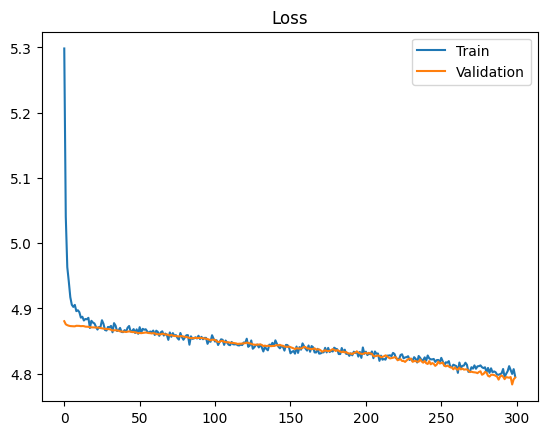

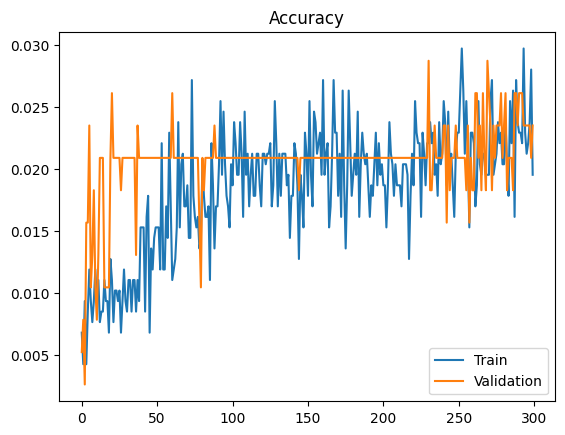

In [46]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [47]:
test_loss, test_acc, test_top_k_accuracy = model.evaluate(test_generator)
print(model.metrics_names)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)
print("The best top 5 accuracy is: ", test_top_k_accuracy*100)

7/7 [==============================] - 3s 346ms/step - loss: 4.7893 - accuracy: 0.0204 - top_k_categorical_accuracy: 0.0867
['loss', 'accuracy', 'top_k_categorical_accuracy']
The test loss is:  4.789318561553955
The best accuracy is:  2.0408162847161293
The best top 5 accuracy is:  8.673469722270966


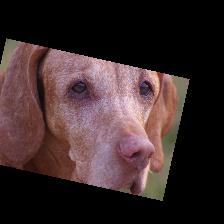

In [52]:
#Testing
img = tf.keras.preprocessing.image.load_img('../photos/dogfacenet10/val/192/192.1.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img


In [54]:
# generate predictions for samples
predictions = model.predict(img_array)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)

# get top 10 predictions
top_10_predictions = np.argsort(predictions[0])[:-11:-1]

# top 10 predictions
for i in range(10):
    print(class_names[top_10_predictions[i]])

1/1 [==============================] - 0s 38ms/step
192
458
143
398
122
373
372
129
200
291


In [69]:
# save model and architecture to single file
model.save(model_path + model_name + '.h5')